# Investigation of ODI Cricket Data

With one of the most dramatic One Day International (ODI) Cricket World Cups there has ever been behind us, here we'll have a close look at some of the statistics behind this weird and wonderful game.

### ODI Cricket Overview

- Each team has 11 players
- Each team has a single 50 over innings (6 balls in an over), to amas their score. The innings ends when they reach 50 overs, lose 10 wickets or catch their oponents score.
- The batting order is decided by the team captain after a coin toss

### Data
The data used in this report has been has been downloaded from [this kaggle kernel](https://www.kaggle.com/venky73/icc-cricket-world-cup-2019-analysis), with some additional data collected directly from [https://www.espncricinfo.com/](https://www.espncricinfo.com/). The data gathering and cleaning process is documented in [ODI_Cricket_Wrangle](ODI_Cricket_Wrangle.ipynb). 

The set contains data collected between 2013 and 2019 up until just before the Cricket World Cup.

## Questions

In this report, we'll try to answer the following questions.

**Win Percentages:**
1. Which team has the highest win percentage overall and in England?
1. How does batting order and coin toss affect each teams performance?
1. How does a losing or winning a match impact on the result of a teams next game?

**Score and runs per over:**
1. What is the relationship between team scores and runs per over?
1. How does winning the toss and batting order affect the scoring rates?
1. How have the scoring average and scoring rates change between 2013 - 2019?

**Recommendations**
 - Statistically, what is the best approach to wining a match?
 
We'll go through each section in order and draw conclusions from the data.

We'll start by creating the necessary paths, importing all modules, reading the .csv files and updating the datatypes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join("../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

from visualization import visualize as vis

df_match = pd.read_csv('../Data/processed/ODI_match_clean.csv')
df_totals = pd.read_csv('../Data/processed/ODI_totals_clean.csv')

# Update column data types
df_match.start_date = pd.to_datetime(df_match.start_date)
cat_cols = ['team1', 'team2', 'ground', 'result']
for col in cat_cols:
    df_match[col] = df_match[col].astype('category')
    
df_totals.start_date = pd.to_datetime(df_totals.start_date)
cat_cols = ['country', 'opposition', 'result','bat']
for col in cat_cols:
    df_totals[col] = df_totals[col].astype('category')
    
c=sb.color_palette()

## Win Percentages

Investigation into team performance based on their win percentages.

### What time of year do each theam play their matches?

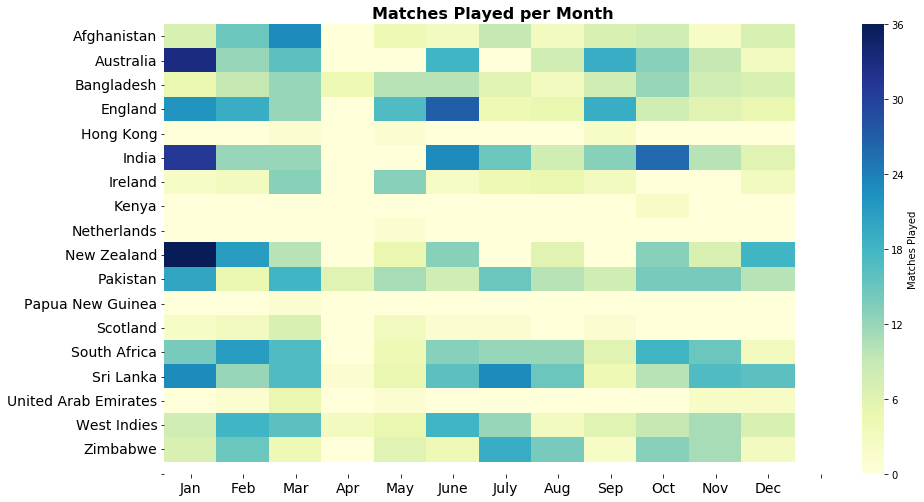

In [2]:
df_temp= df_totals.copy()
df_temp['month'] = df_temp.start_date.dt.month
df_temp['month'] = df_temp.month.astype('category')

grouped = df_temp.groupby(['country', 'month']).count()['match_id']
values = np.where(grouped.isnull(), 0, grouped)
values = values.reshape(18,12)

vis.setPlot();
sb.heatmap(values, cmap='YlGnBu', cbar_kws={'label':'Matches Played'}, annot=False);

y_locs, y_labels = plt.yticks()
x_locs, x_labels = plt.xticks()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct','Nov', 'Dec']

plt.xticks(np.arange(0.5,13,1), months, rotation=0);
plt.yticks(np.arange(0.5,19.5,1), grouped.index.levels[0], rotation=0, va='center');
plt.title("Matches Played per Month", fontsize=16, fontweight='bold');

#### Observations
- The heatmap shows us that there are almost zero matches in the dataset which are played in April. Perhaps this marks the end of the cricket season in some areas of the world and is before the start of the season elsewhere.
- We can also see that Kenya, Netherlands, Papau New Guinea, Scotland and United Arab Emirates have not played many macthes.
***

### Which team has the highest overall win percentage?
### How does a losing or winning a match impact on the result of a teams next game?

We need to create a new dataframe and make the `result` variable a dummy variable. This enables us to calculate proportions more easily. We will remove all 'n/r' results. Only 'won' results are assigned 1, 'tied' and 'lost' are assigned 0.

In [3]:
df_pcnts = df_totals.copy()
df_pcnts = df_pcnts.merge(df_match.loc[:,['match_id','ground']], on='match_id')
df_pcnts.country = df_pcnts.country.astype(object)
df_pcnts = df_pcnts[df_pcnts.result.isin(['won','lost', 'tied'])]
df_pcnts['result_dum'] = np.where(df_pcnts.result=="won",1,0)

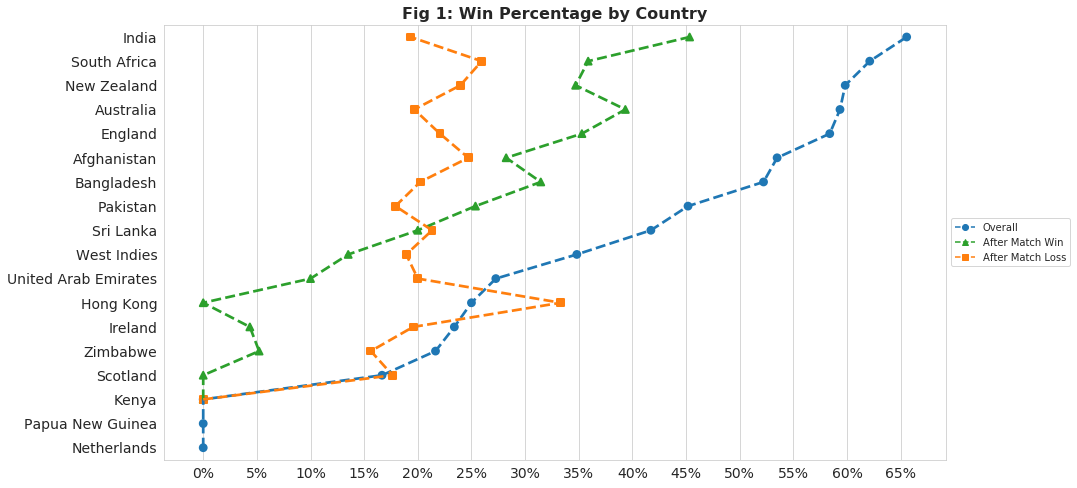

In [4]:
# Overall win proportions
win_prop = df_pcnts.groupby('country').mean()['result_dum'].sort_values()
order= win_prop.index

# Win after result proportions
lose_win_prop = vis.winAfterLoss(df_pcnts, order)
win_win_prop = vis.winAfterWin(df_pcnts, order)

sb.set_style("whitegrid")

vis.setPlot(figsize=[14,8])
s1 = sb.pointplot(x=win_prop.values, y=win_prop.index, order=order, color=c[0], 
                      linestyles='--', markers='o')
s2 = sb.pointplot(x=win_win_prop.values.flatten(), y=win_win_prop.index, order=order, color=c[2], 
                      linestyles='--', markers='^')
s3 = sb.pointplot(x=lose_win_prop.values.flatten(), y=lose_win_prop.index, order=order, color=c[1], 
                      linestyles='--', markers=',')

# Create art for legend
l0 = mlines.Line2D([],[],color=c[0], linestyle='--', marker='o')
l1 = mlines.Line2D([],[],color=c[1], linestyle='--', marker='s')
l2 = mlines.Line2D([],[],color=c[2], linestyle='--', marker='^')

plt.legend((l0,l2,l1), ('Overall', 'After Match Win', 'After Match Loss'), title="", 
          loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Fig 1: Win Percentage by Country", fontsize=16, fontweight='bold');
plt.gca().invert_yaxis();

ticks = np.arange(0,0.7,0.05)
labels = ['{:.0f}%'.format(i*100) for i in ticks]

plt.xticks(ticks, labels)
plt.ylabel("");
plt.xlabel("");


#### Observations
- Figure 1 shows the overall win percentage per team alongside the breakdown of whether those wins occur after a match win or a match loss.
- India are the most successful team in terms of overall win percentage and proportion of win streaks, winning 25% more matches after having won their previous match.
- The top 10 countries in this table are the countries which took part in this years world cup. Lets see how they perform on English soil.

### Which team has the highest win percentage in England?
### How does a losing or winning a match impact on the result of a teams next game?

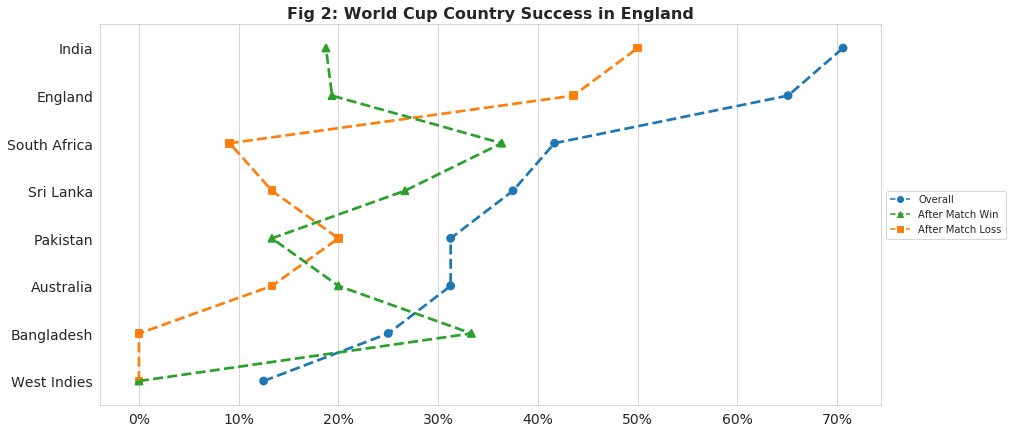

In [5]:
english_grounds = ['The Oval', 'Birmingham', 'Cardiff', 'Nottingham', 'Southampton', 'Leeds', "Lord's", 
                   'Manchester', 'Chester-le-Street', 'Bristol', 'East London']
cup_countries = ['Afghanistan', 'Australia', 'Bangladesh', 'England', 'India', 'Pakistan', 
                 'South Africa', 'Sri Lanka', 'West Indies']

# Win proportions in England
win_prop = df_pcnts[(df_pcnts.ground.isin(english_grounds))&
                      (df_pcnts.country.isin(cup_countries))].groupby('country').mean()['result_dum'].sort_values()
order= win_prop.index

# Proportions after match result
win_win_prop = vis.winAfterWin(df_pcnts[(df_pcnts.ground.isin(english_grounds))&(df_pcnts.country.isin(cup_countries))],
                              countries=cup_countries)
lose_win_prop = vis.winAfterLoss(df_pcnts[(df_pcnts.ground.isin(english_grounds))&(df_pcnts.country.isin(cup_countries))],
                              countries=cup_countries)

sb.set_style("whitegrid")

vis.setPlot(figsize=[14,7])
sb.pointplot(x=win_prop.values, y=win_prop.index, color=c[0], order=order, linestyles='--', markers='o');
sb.pointplot(x=win_win_prop.values.flatten(), y=win_win_prop.index, color=c[1], order=order, linestyles='--', markers='s');
sb.pointplot(x=lose_win_prop.values.flatten(), y=lose_win_prop.index, color=c[2], order=order, linestyles='--', markers='^');

# Create art for legend
l0 = mlines.Line2D([],[],color=c[0], linestyle='--', marker='o')
l1 = mlines.Line2D([],[],color=c[1], linestyle='--', marker='s')
l2 = mlines.Line2D([],[],color=c[2], linestyle='--', marker='^')

plt.legend((l0,l2,l1), ('Overall', 'After Match Win', 'After Match Loss'), title="",
          loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Fig 2: World Cup Country Success in England", fontsize=16, fontweight='bold');
plt.gca().invert_yaxis();

ticks = np.arange(0,0.8,0.1)
labels = ['{:.0f}%'.format(i*100) for i in ticks]

plt.xticks(ticks, labels)
plt.ylabel("");
plt.xlabel("");


#### Observations
- India and England are the most successful teams on English grounds.
- India sit atop this chart and the overall charts. Its clear to see why they were strong contenders going into this World Cup. 
- Afghanistan have not played in any matches in England so were a mystery team heading into the World Cup.
- South Africa are the most dangerous team when on a winning streak in England, winning over 35% of their matches having won their previous match. They are vulnerable after losing though, winning only 10% of their matches.
***

### How does the result of the coin toss affect a teams performance?

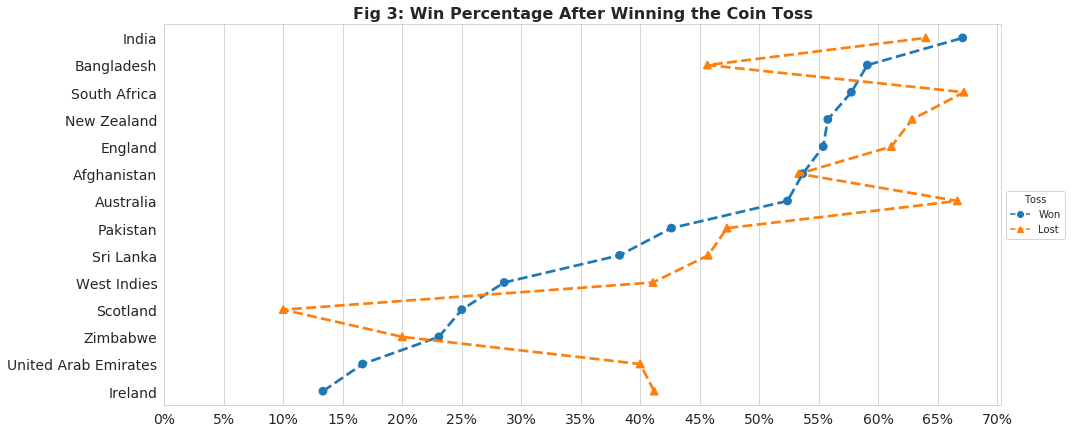

In [6]:
# Win after winning toss proportions
win_win = df_pcnts[df_pcnts.toss=='won'].groupby('country').mean()['result_dum'].sort_values().dropna().tail(14)
order = win_win.index

# Win after losing toss proportions
lose_win = df_pcnts[df_pcnts.toss=='lost'].groupby('country').mean()['result_dum'][order].dropna()

ticks = np.arange(0,0.75,0.05)
labels = ['{:.0f}%'.format(i*100) for i in ticks]

sb.set_style("whitegrid")

vis.setPlot(figsize=[15,7]);
s1 = sb.pointplot(x=win_win.values, y=win_win.index, order=order, color=c[0], 
                      linestyles='--', markers='o')

s2 = sb.pointplot(x=lose_win.values, y=lose_win.index, order=order, color=c[1], 
                      linestyles='--', markers='^')

# Create art for legend
l0 = mlines.Line2D([],[],color=c[0], linestyle='--', marker='o')
l1 = mlines.Line2D([],[],color=c[1], linestyle='--', marker='^')

plt.legend((l0,l1), ('Won', 'Lost'), title="Toss", loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Fig 3: Win Percentage After Winning the Coin Toss", fontsize=16, fontweight='bold');
plt.gca().invert_yaxis();

plt.xticks(ticks, labels)
plt.ylabel("");
plt.xlabel("");

#### Coin Toss Observations
- Fig 3 shows some interesting results. In general, the team who loses the coin toss wins a higher proportion of matches. Perhaps there is less pressure on them to justify the batting decision made by their captain.

### How does batting order affect a teams performance?

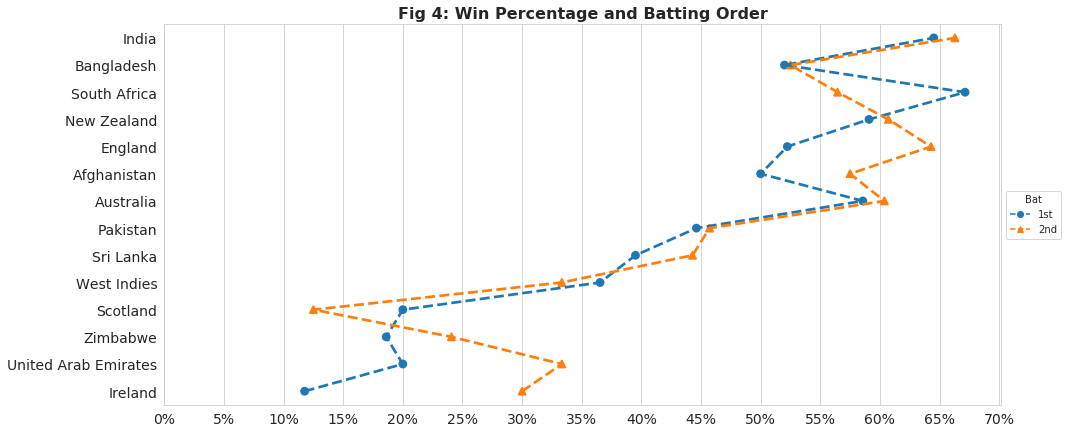

In [7]:
# Win after batting 1st proportions
bat1win= df_pcnts[df_pcnts.bat=='1st'].groupby('country').mean()['result_dum'].sort_values()[order]

# Win after batting 2nd proportions
bat2win = df_pcnts[df_pcnts.bat=='2nd'].groupby('country').mean()['result_dum'][order][order]

sb.set_style("whitegrid")

vis.setPlot(figsize=[15,7]);
s1 = sb.pointplot(x=bat1win.values, y=bat1win.index, order=order, color=c[0], linestyles='--', markers='o')

s2 = sb.pointplot(x=bat2win.values, y=bat2win.index, order=order, color=c[1], linestyles='--', markers='^')

l0 = mlines.Line2D([],[],color=c[0], linestyle='--', marker='o')
l1 = mlines.Line2D([],[],color=c[1], linestyle='--', marker='^')

plt.legend((l0,l1), ('1st', '2nd'), title="Bat", loc='center left', bbox_to_anchor=(1, 0.5))

plt.title("Fig 4: Win Percentage and Batting Order", fontsize=16, fontweight='bold');
plt.gca().invert_yaxis();

plt.xticks(ticks, labels)
plt.ylabel("");
plt.xlabel("");

#### Batting order observations
- In most cases there is marginal difference in a teams overall win percentage when batting first or second. 
- England have more success when batting second, winning 10% more of their matches when batting second.
- Afghanistan also have more success when batting second, winning 5% more of their matches when batting second.
- South Africa win nearly 10% more of their matched when batting first.

## Score and runs per over

Investigation into the relationship between total runs scored and runs per over.

## What is the relationship between team scores and runs per over?

In [8]:
df_temp=df_totals.copy()

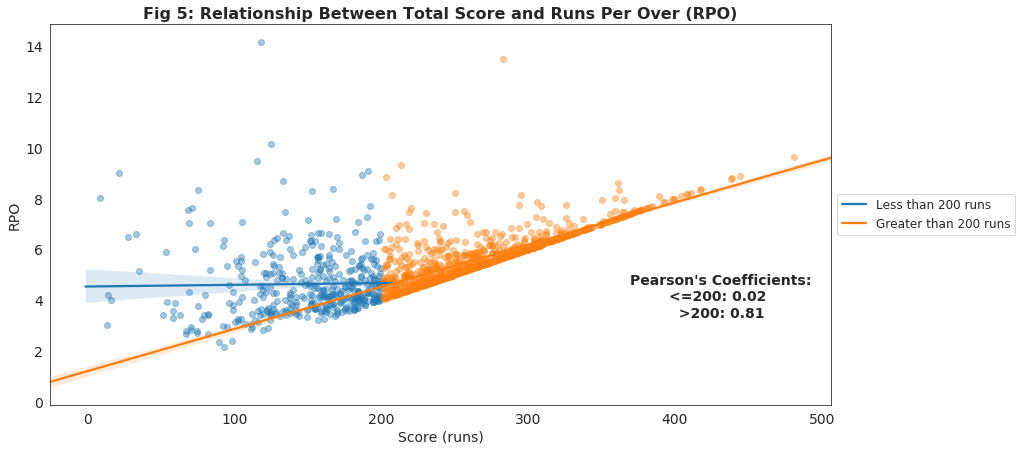

In [9]:
sb.set_style("white")
fig = plt.figure(figsize=[14,7])

sb.regplot(data=df_temp[df_temp.score_total <= 200], y='rpo', x='score_total', scatter_kws={'alpha':0.4});
sb.regplot(data=df_temp[df_temp.score_total > 200], y='rpo', x='score_total', scatter_kws={'alpha':0.4});

plt.title("Fig 5: Relationship Between Total Score and Runs Per Over (RPO)", fontsize=16, fontweight='bold');

plt.legend(fontsize=12,labels=['Less than 200 runs', 'Greater than 200 runs'], 
           loc='center left', bbox_to_anchor=(1, 0.5));
plt.xlabel("Score (runs)", fontsize=14);
plt.ylabel("RPO", fontsize=14);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

# Calculate coefficients
corr1 = df_temp[df_temp.score_total <= 200].rpo.corr(df_temp[df_temp.score_total <= 200].score_total)
corr2 = df_temp[df_temp.score_total > 200].rpo.corr(df_temp[df_temp.score_total > 200].score_total)

fig.text(0.7,0.3, "Pearson's Coefficients:\n        <=200: {:.2f}\n          >200: {:.2f}".format(corr1, corr2),
        fontsize=14, fontweight='bold');


#### Observations
This chart shows some fairly interesting trends.
- Scores less than 200 runs has almost no positive correlation with rpo, with a pearsons cofficient of 0.02.
- Scores greater than 200 runs have a strong positive correlation with rpo, with a pearsons cofficient of 0.81.
- This increase in correlation strength gives rise to the hockey stick shape of the distribution.
- There is a dense line of points which form a baseline of which there are no points below. Scores below this line are impossible to achieve in 50 overs with that value of rpo.

## How does winning the toss and batting order affect the scoring rates?
We saw earlier that for most teams there was very little difference in win percentage when batting first or second, but how is the average score affected?

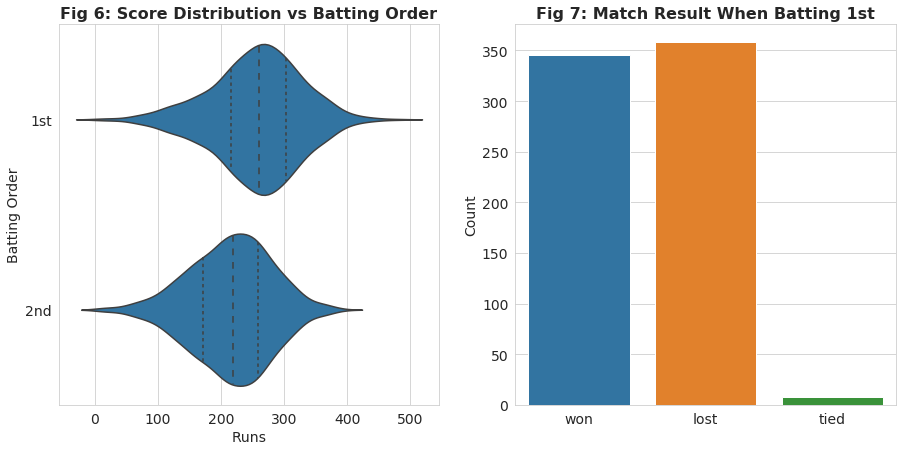

In [10]:
sb.set_style("whitegrid")

plt.figure(figsize=[15,7])
plt.subplot(1,2,1)
sb.violinplot(data=df_totals, y="bat", x='score_total', color=c[0], inner='quartile', order=['1st','2nd']);
plt.title("Fig 6: Score Distribution vs Batting Order", fontsize=16, fontweight='bold');
plt.xlabel("Runs", fontsize=14);
plt.ylabel("Batting Order", fontsize=14);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.subplot(1,2,2)
sb.barplot(x=['won', 'lost','tied'], y=[((df_totals.result=="won") & (df_totals.bat=="1st")).sum(), 
                                    ((df_totals.result=="lost") & (df_totals.bat=="1st")).sum(),
                                       ((df_totals.result=="tied") & (df_totals.bat=="1st")).sum()]);
plt.title("Fig 7: Match Result When Batting 1st", fontsize=16, fontweight='bold');
plt.ylabel("Count", fontsize=14);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

#### Observations
- Here we see that the average score for teams batting second is around 50 runs less than a team batting first, yet the number of matched won by teams batting first is slightly less than teams batting second.
- This is because it is impossible for a team batting second to surpass the score of the team batting first by more than 6 runs since the game finishes when they reach this point, regardless off the number of overs bowled.
- Because of this, we'll use the average runs per over of a team as a measure of score performance.

## How have the scoring average and scoring rates change between 2013 - 2019?

Here we'll at the pattern of average rpo for each team since the score average may be skewed to the left by teams batting second.

In [11]:
# Extract year information from start date
df_temp['year'] = df_temp.start_date.dt.year

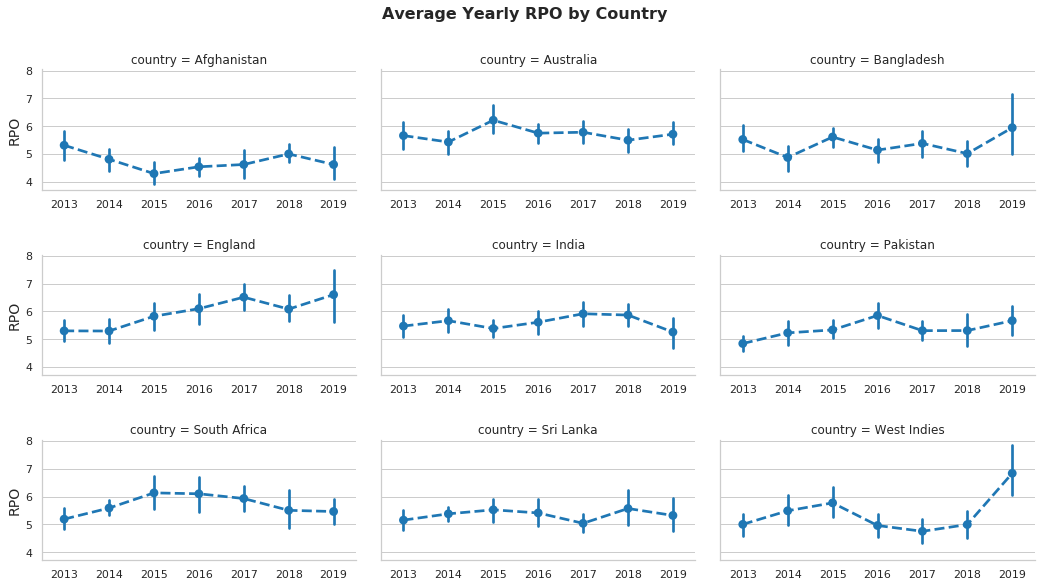

In [12]:
def pointplot(x,y,hue,**kwargs):
    sb.pointplot(x=x,y=y, hue=hue, **kwargs)
    
sb.set(style="whitegrid")

g = sb.FacetGrid(data=df_temp, col='country', col_order=cup_countries, col_wrap=3, 
                 height = 8.27/4,  aspect = (14.70/3)/(8.27/4), sharex=False, despine=True)


g.map(pointplot, 'year', 'rpo', hue=None, color=c[0], linestyles='--', ci=95)
vis.setSeabornFigPlot(plot = g, xlabel = '', ylabel = "RPO",
                      title = "Average Yearly RPO by Country")


#### Observations
- The average rpo's for each team generally oscillate around an average.
- Enlgand have shown the most consistent improvemnet of rpo since 2013, increassing by almost 0.5 runs per over each year.
- The West Indies see a significant increase in there average rpo for 2019, however, with not many matches played yet the average is more susceptible to skew from extreme results.

Lets now look at how runs per over relates to the result of the match.

### How do scoring rates relate to the match result?

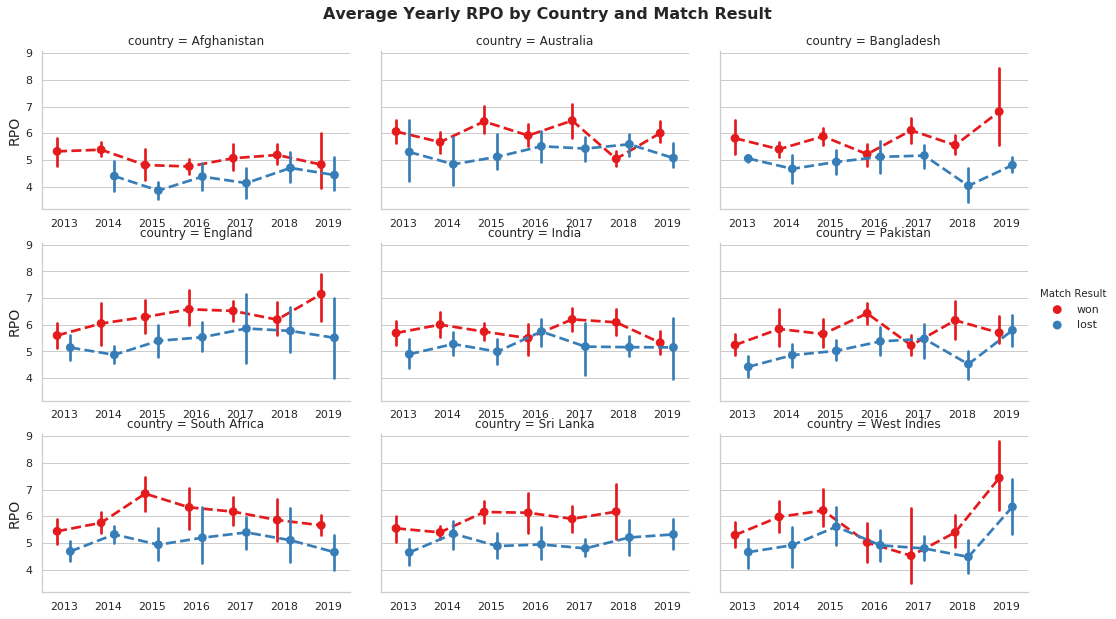

In [13]:
def pointplot(x,y,hue,**kwargs):
    sb.pointplot(x=x,y=y, hue=hue, **kwargs)

g = sb.FacetGrid(data=df_temp, col='country', col_order=cup_countries, col_wrap=3, height=4, sharex=False)
g.map(pointplot, 'year', 'rpo', 'result', hue_order=['won','lost'], dodge=0.3, 
      palette="Set1", linestyles='--', ci=95);

vis.setSeabornFigPlot(g, title="Average Yearly RPO by Country and Match Result", ylabel="RPO");
g.add_legend(title="Match Result");

#### Observations

As we might expect that the average rpo for each team is higher for games in which they win than ones where they lose. However, there are some interesting exceptions.
- In 2018, Australia won more games when scoring a lower rpo.
- We see the same for the West indies and Pakistan in 2017.
- Due to overalap of the 95% confidence intervals we cannot be certain that these observation do not arise through random chance.


## Overall Performance Recommendations

 - Statistically, what is the best approach to wining a match?

In this section we engineer a new feature `score_vs_avg` which provides a delta between the average runs scored on a ground and the total runs score for each team. In the exploratory phase, we found this provides the best separation of the score distributions between winning and losing scores if we only included teams batting first. This avoids the left skew in the data created by winning teams who bat second.

In [14]:
# Engineer new feature to calculate score delta to ground average
ground_avg_score = df_pcnts.groupby('ground').mean()['score_total']
df_pcnts['score_vs_avg'] = np.NaN

for ground, avg in zip(ground_avg_score.index, ground_avg_score.values):
    df_pcnts['score_vs_avg'] = np.where(df_pcnts.ground == ground, df_pcnts.score_total
                                        - avg, df_pcnts.score_vs_avg)

### What are the distributions of winning and losing scores when compared to the average number of runs scored at that ground?

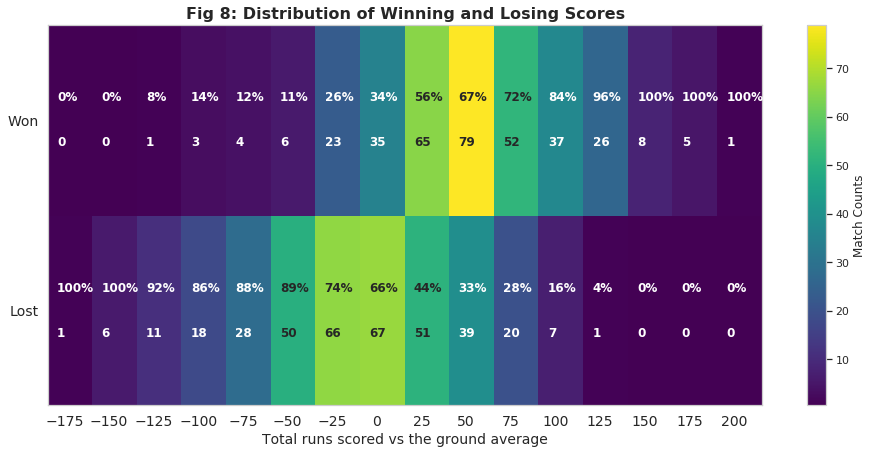

In [15]:
bins = np.arange(df_pcnts.score_vs_avg.min(), df_pcnts.score_vs_avg.max()+25,25)

vis.setPlot(title="Fig 8: Distribution of Winning and Losing Scores",figsize=[16,7])
h2, xbins, ybins, _ = plt.hist2d(data=df_pcnts[df_pcnts.bat=='1st'], x='score_vs_avg', y='result_dum', 
                                 bins=[bins, [0,0.5,1]], vmin=0.5, cmap='viridis');

plt.yticks((0.25,0.75),('Lost','Won'))
plt.xlabel("Total runs scored vs the ground average")
plt.colorbar(label='Match Counts');
plt.xticks(np.arange(-175,201,25))

# Calculate proportions for each bin and create labels
pcnts=[]
labels = []
for i in range(len(ybins)-1):
    pcnts.append([(h2[j][i]/np.sum(h2[j])) for j in range(len(xbins)-1)])
    labels.append(vis.tickLabels(pcnts[i], pcnt=True, f=0))

# Annotate bins with counts and proportions
for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        ax = plt.gca()
        if h2[j,i] > 40:
            ax.text(xbins[j]+5, ybins[i]+0.25, "{}\n\n\n{}".format(labels[i][j], int(h2[j,i])), 
                    va="center", fontweight="bold")
        else:
            ax.text(xbins[j]+5, ybins[i]+0.25, "{}\n\n\n{}".format(labels[i][j], int(h2[j,i])),
                    color="w", va="center", fontweight="bold") 

#### Notes
- We have engineered a new feature `score_vs_avg` which calculates the score as a delta against the ground average.
- The ground average is calculated from the full sample games played at each ground.
- In the exploratory phase, we found that this feature provides the best separation of the score distributions when only including teams batting first. This avoids the left skew in the data created by winning teams who bat second.

#### Observations
- The disitrbution of losing scores peaks between +15 and -35 runs. In this range, **twice** as many matches are **lost** than won.
- The distribution of winning scores peaks at +40 and +65 runs. In this range, **twice** as many matches are **won** than lost.
- Teams that score more than 40 runs above the ground average win 75% of their matches.
- The number of matches won and lost when between +15 and +40 runs are scored compared to the average are **evenly distributed**.

### What are the distributions of wickets lost for winning and losing teams?

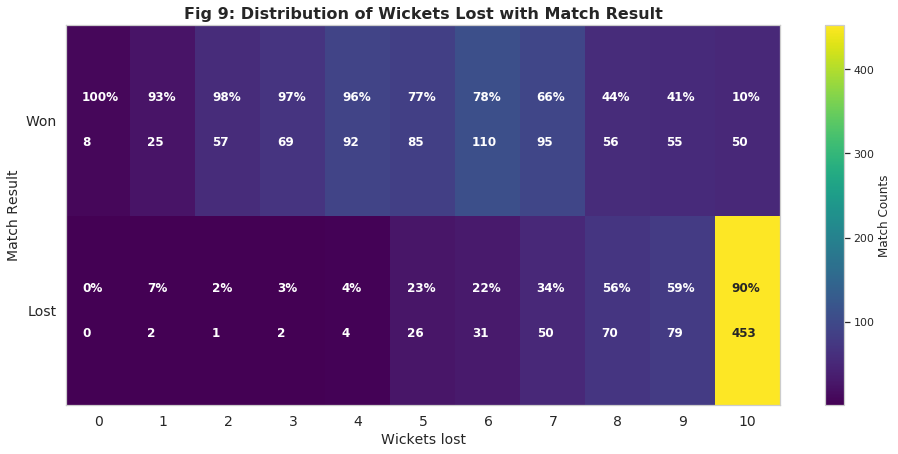

In [16]:
bins = np.arange(0,12,1)

vis.setPlot(title="Fig 9: Distribution of Wickets Lost with Match Result", figsize=[16,7])
h2, xbins, ybins, _ = plt.hist2d(data=df_pcnts, x='wickets', y='result_dum', bins=[bins, [0,0.5,1]],
                                 vmin=0.5, cmap='viridis');
plt.yticks((0.25,0.75),('Lost','Won'));
plt.xticks(np.arange(0.5,11,1), bins[:-1])

plt.xlabel("Wickets lost");
plt.ylabel("Match Result");
plt.colorbar(label='Match Counts');

# Calculate proportions for each bin and create labels
pcnts=[]
labels = []
for i in range(len(ybins)-1):
    pcnts.append([(h2[j][i]/np.sum(h2[j])) for j in range(len(xbins)-1)])
    labels.append(vis.tickLabels(pcnts[i], pcnt=True, f=0))

# Annotate bins with counts and proportions
for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        ax = plt.gca()
        if h2[j,i] > 400:
            ax.text(xbins[j]+0.25, ybins[i]+0.25, "{}\n\n\n{}".format(labels[i][j], int(h2[j,i])), 
                    va="center", fontweight="bold")
        else:
            ax.text(xbins[j]+0.25, ybins[i]+0.25, "{}\n\n\n{}".format(labels[i][j], int(h2[j,i])),
                    color="w", va="center", fontweight="bold") 

#### Notes
- Fig 9 shows the proportion of matches won and lost associated with the number of wickets lost, and the counts associated with each.

#### Observations
- The distribution of wickets lost for losing teams is very strongly skewed to the left.
- The distribution of wickets lost for teams who won the match is much less strongly left skewed, peaking at 6 wickets lost.
- Teams that lose all 10 wickets lose 90% of the time, and lose nearly 6 times more than teams who lose 9 wickets.
- Teams who lose 7 wickets in an innings win twice as many matches than they lose.
- Teams that lose more than 8 wickets in a match are more likely to lose than win.
- 336 matches are won when 5 wickets or less are lost. Only 35 matches lost when 5 wickets or less are lost. Therefore, teams that lose 5 wickets or less win 90% of their matches.

## Conclusions
We have seen some interesting and curious trends within that data. Here are the key points and recommendations:
- India and England are the most prolific team in English conditions, winning 20-25% more matches in England than their next best rival, South Africa.
- South Africa are dangerous after a win and vulnerable after a loss in England, winning 35% and 10% of their matches respectively.
- In general, batting first or second had little affect on a teams success, but **losing** the toss benefited most teams.
- England have shown the most consistent improvement in runs scored per over. Combine this with their success on home soil they are a force to be reckoned with.
- Teams who score between 40-65 runs greater than the ground average are twice as likely to win the match.
- Teams that score more than 40 runs above the ground average win 75% of their matches.
- Teams who score between 15 runs greater and 35 runs less than the ground average are twice as likely to lose the match.
- Teams that lose less than 8 wickets in an innings are much more likely to win, while teams who lose 5 wickets or less win 90% of their matches.

Thank you for reading!